# Import dependencies

In [1]:
import math
import matplotlib.pyplot as plt
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torchvision
import pandas as pd
import tqdm

import utils
from model.CustomConvNet import CustomConvNet
from dataset.FashionMNISTDataset import FashionMNISTDataset


d:\code\PytorchNonstop\ComputerVision\FashionMNIST\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Device configuration

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Hyperparameters and constants

In [3]:
num_epochs = 5
batch_size = 64
learning_rate = 0.01
split_rate = 0.7

num_classes = 10
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
save_dir = "data/"

# Dataset

In [16]:
# Run below lines to create image data
# utils.download_fmnist_img_data(is_training=True, save_dir=save_dir)
# utils.download_fmnist_img_data(is_training=False, save_dir=save_dir)

In [5]:
full_train_dataset = FashionMNISTDataset(img_dir=save_dir+"train/", annotation_file=save_dir+"train_annotation.csv")
train_size = math.floor(split_rate * len(full_train_dataset))
valid_size = len(full_train_dataset) - train_size
train_dataset, valid_dataset = random_split(full_train_dataset, lengths=[train_size, valid_size])
test_dataset = FashionMNISTDataset(img_dir=save_dir+"test/", annotation_file=save_dir+"test_annotation.csv")

# Data loader

In [6]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True)
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=batch_size,
                              shuffle=True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)

In [7]:
images, labels = next(iter(train_dataloader))
print(f"Batch data shape: {images.shape}")
print(f"Batch label shape: {labels.shape}")

Batch data shape: torch.Size([64, 1, 28, 28])
Batch label shape: torch.Size([64])


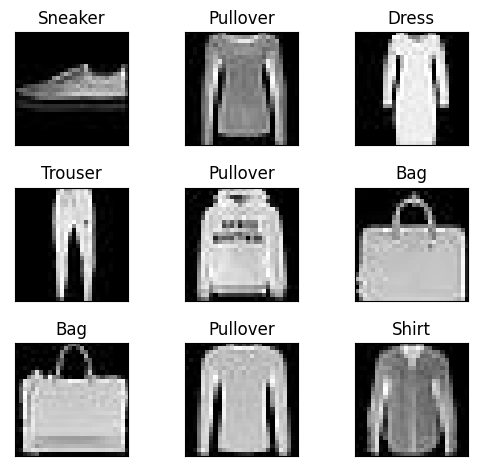

In [8]:
plt.figure(figsize=[5, 5])
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.tight_layout()
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(labels_map[labels[i].item()])
    plt.xticks([])
    plt.yticks([])

# Convolutional neural network

In [9]:
model = CustomConvNet(num_classes=num_classes).to(device)
model.train()

CustomConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

# Loss and optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model

In [15]:
for epoch in range(num_epochs):
    with tqdm.tqdm(train_dataloader, unit="batch", leave=True, position=0) as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}")
        train_loss = 0
        for images, labels in train_dataloader:
            tepoch.update(1)
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss / len(train_dataloader)
            tepoch.set_postfix(train_loss=loss.item())
        
        valid_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in valid_dataloader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                predicted = torch.argmax(outputs, dim=1)

                valid_loss += loss / len(train_dataloader)
                total += len(labels)
                correct += (predicted == labels).sum().item()
        
        valid_accuracy = correct / total
        tepoch.set_postfix(train_loss=train_loss.item(), 
                           valid_loss=valid_loss.item(), 
                           valid_accuracy=valid_accuracy)

Epoch 5: 100%|██████████| 657/657 [01:12<00:00,  9.12batch/s, train_loss=0.194, valid_accuracy=0.892, valid_loss=0.135]


# Test the model

In [12]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)

        correct = (predicted == labels).sum().item()
        total = len(labels)
    
    print(f"Test accuracy: {correct/total}")

Test accuracy: 0.875


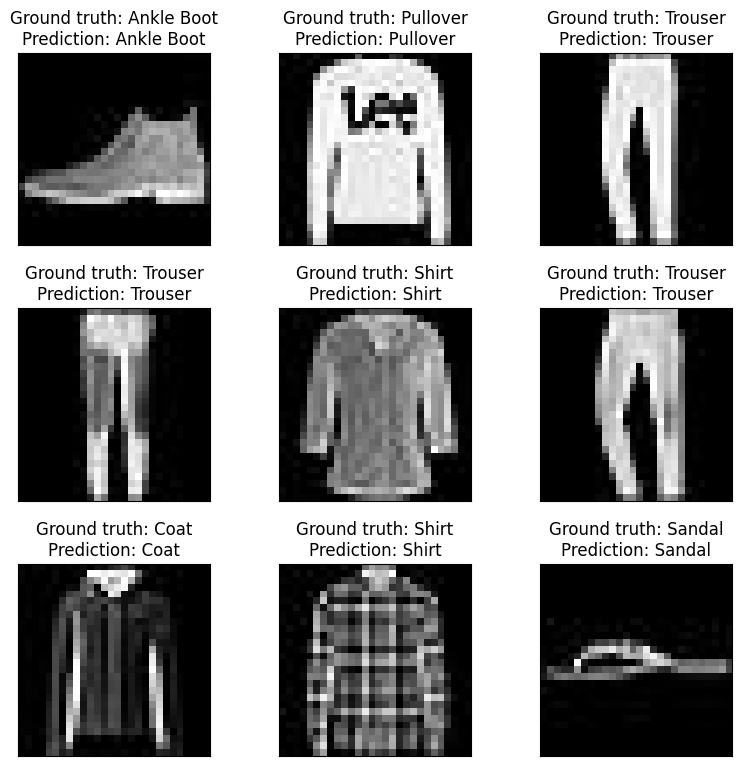

In [13]:
images, labels = next(iter(test_dataloader))
predicted = torch.argmax(model(images.to(device)), dim=1)
plt.figure(figsize=[8, 8])
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.tight_layout()
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(f"Ground truth: {labels_map[labels[i].item()]}\nPrediction: {labels_map[predicted[i].item()]}")
    plt.xticks([])
    plt.yticks([])  